# Twitter Sentiment Classification: Positive vs. Negative

In [142]:
import pandas as pd

df_train = pd.read_csv('../data/twitter_sentiment_train.csv')
df_test  = pd.read_csv('../data/twitter_sentiment_test.csv')

# Shuffle train set
RANDOM_STATE = 123
df_train = df_train.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [143]:
import pickle
print("Loading model and vectorizer...")

with open("../data/sarcasm_model.pkl", "rb") as f:
    sarcasm_model = pickle.load(f)

with open("../data/dict_vectorizer.pkl", "rb") as f:
    vec = pickle.load(f)

Loading model and vectorizer...


In [144]:
int_to_label = {1: 'Positive', 0: 'Negative'}

In [145]:
df_train.head(5)

,text,label
0,Batman the #killing joke 1st printing nm 9.4 #...,1
1,the sun is so stupid they know how much the bo...,0
2,@user trying to do the same ha. But I've been ...,1
3,"""Prince George turns 2: His best style moments...",1
4,Hulk Hogan hit rock bottom Friday when he was ...,0


### Import libraries

In [146]:
import re
import string
import json
import emoji
import spacy
from tqdm import tqdm
from textblob import TextBlob
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from pre_processing import *

nlp = spacy.load("en_core_web_sm")

In [147]:
with open('../data/profanity.txt', 'r') as f: 
    profanity_words = f.readlines()
profanity_words = [s.strip() for s in profanity_words]

In [148]:
punct_list = ['!','#','@','?']

### Feature Extraction Checklist

1. Profanity words count
2. Sentiment and Subjectivity 
3. Emoji Sentiment + Emoticon e.g :), 😂, :((
3. Fully Capitalized
4. Punctuations

In [149]:
def count_all_capital_tokens(text: str) -> dict:
    """
    Counts the number of fully capitalized tokens (all letters uppercase) in a given text.
    Returns: {'all_capital_token_count': count}
    """
    matches = re.findall(r'\b[A-Z][A-Z]+\b', text)
    return {'all_capital_token_count': len(matches)}

def count_specified_punctuations(text: str, punct_list: list) -> dict:
    """
    Counts the occurrences of each punctuation mark in a given text.
    Returns: {'punctuation_char1': count1, 'punctuation_char2': count2, ...}
    """
    punct_occur = {}
    for char in punct_list:
        punct_occur[char] = 0
    for char in text:
        if char in punct_list:
            punct_occur[char] += 1
    return punct_occur

def count_profanity_words(text: str, profanity_list: list) -> dict:
    """
    Counts the number of profanity words in a given text using a predefined list.
    Returns: {'profanity_word_count': count}
    """
    count = 0
    # Normalize both input and the word list using the to_lower() function
    profanity_list = [s.lower() for s in profanity_list]
    tokenized_sent = run_pipeline(text, [word_tokenize_sentence, to_lower])
    for sent in tokenized_sent:
        for token in sent:
            if token in profanity_list:
                count += 1
    return {'profanity_word_count': count}

def count_sad_emoticons(text: str):
    """
    Returns the occurrences of sad emoticons.
    Returns: {
      "sad_emoticon": count
    }
    """
    # Sad, crying, angry, and negative emoticons
    matches = re.findall(r':\(|:\||:\/|:\\|:\'\(|>:\(|D:|:<|:c|;\(|T_T|T\.T', text)
    return {"sad_emoticon": len(matches)}

def count_happy_emoticons(text: str):
    """
    Returns the occurrences of happy emoticons.
    Returns: {
      "happy_emoticon": count
    }
    """
    # Happy, excited, laughing, and positive emoticons
    matches = re.findall(r':\)|:D|;D|=\)|;-\)|:\}\)|:>|=\]|8\)|;-D|XD|xD|x-D|X-D|<3|:\*|;-\*|;\)|=D', text)
    return {"happy_emoticon": len(matches)}

def count_not(text: str):
    matches = re.findall(r'dnt|ont|not', text)
    return {'not_count': len(matches)}

def count_elongated_words(text):
    matches = re.findall(r'\b\w*(\w)\1{2,}\w*\b', text)
    return {'elongated_word_count': len(matches)}

def count_positive_words(text):
    positive_words = ['good', 'happy', 'love', 'great', 'excellent']
    tokens = str(text).lower().split()
    return {'positive_word_count': sum(1 for t in tokens if t in positive_words)}

def count_negative_words(text):
    negative_words = ['bad', 'sad', 'hate', 'terrible', 'awful']
    tokens = str(text).lower().split()
    return {'negative_word_count': sum(1 for t in tokens if t in negative_words)}

def uppercase_ratio(text):
    total_letters = sum(1 for c in text if c.isalpha())
    return {'uppercase_ratio': sum(1 for c in text if c.isupper()) / total_letters} if total_letters else {'uppercase_ratio': 0}

# Load emoji JSON
with open("../data/emoji_polarity.json", "r", encoding="utf-8") as f:
    emoji_json = json.load(f)

# Load emoticon JSON
with open("../data/emoticon_polarity.json", "r", encoding="utf-8") as f:
    emoticon_json = json.load(f)

# Merge both dictionaries
combined_sentiment = {**emoji_json, **emoticon_json}

def get_sentiment_and_subjectivity(text: str) -> dict:
    blob = TextBlob(text)
    pol = blob.sentiment.polarity
    subj = blob.sentiment.subjectivity
    
    tb_pos = pol if pol > 0 else 0
    tb_neg = abs(pol) if pol < 0 else 0

    # Find all emojis and emoticons in text
    items_in_text = [ch for ch in text if ch in emoji.EMOJI_DATA]  # emojis
    # emoticons (like :) ;D) — check by splitting text
    for em in combined_sentiment:
        if em in text and em not in items_in_text:
            items_in_text.append(em)

    if items_in_text:
        pos_list = [combined_sentiment[i]["positivity"] for i in items_in_text if i in combined_sentiment]
        neg_list = [combined_sentiment[i]["negativity"] for i in items_in_text if i in combined_sentiment]

        if pos_list:
            avg_pos = sum(pos_list) / len(pos_list)
            avg_neg = sum(neg_list) / len(neg_list)
            w_pos_emoji = 0.5
            final_pos = (tb_pos * (1-w_pos_emoji) + w_pos_emoji * avg_pos) 
            w_neg_emoji = 0.5
            final_neg = (tb_neg * (1-w_neg_emoji) + w_neg_emoji * avg_neg)  
        else:
            final_pos, final_neg = tb_pos, tb_neg
    else:
        final_pos, final_neg = tb_pos, tb_neg

    return {
        "positive_sentiment": final_pos,
        "negative_sentiment": final_neg,
        "subjectivity": subj
    }

def count_pos_tags(text):
    """
    Count different POS tags in a tweet.
    Returns a dict with counts for common POS categories.
    """
    doc = nlp(text)
    pos_counts = {
        "num_nouns": 0,
        "num_verbs": 0,
        "num_adjectives": 0,
        "num_adverbs": 0,
        "num_pronouns": 0,
    }
    for token in doc:
        if token.pos_ == "NOUN":
            pos_counts["num_nouns"] += 1
        elif token.pos_ == "VERB":
            pos_counts["num_verbs"] += 1
        elif token.pos_ == "ADJ":
            pos_counts["num_adjectives"] += 1
        elif token.pos_ == "ADV":
            pos_counts["num_adverbs"] += 1
        elif token.pos_ == "PRON":
            pos_counts["num_pronouns"] += 1
    return pos_counts

def count_named_entities(text):
    """
    Count the number of named entities by type in a tweet.
    Returns a dict with counts for common entity types.
    """
    doc = nlp(text)
    ner_counts = {
        "num_PERSON": 0,
        "num_ORG": 0,
        "num_LOC": 0,
        "num_DATE": 0,
        "num_MONEY": 0,
        "num_MISC": 0,
    }
    for ent in doc.ents:
        if ent.label_ in ner_counts:
            ner_counts[f"num_{ent.label_}"] += 1
        else:
            ner_counts["num_MISC"] += 1
    return ner_counts

def get_hashtag_polarities(text: str) -> dict:
    hashtags = re.findall(r"#\w+", text)
    polarities = [TextBlob(tag[1:]).sentiment.polarity for tag in hashtags]
    
    if polarities:
        return {
            # "hashtag_avg_polarity": sum(polarities)/len(polarities),
            # "hashtag_max_polarity": max(polarities),
            # "hashtag_min_polarity": min(polarities),
            "hashtag_count": len(polarities)
        }
    else:
        return {
            # "hashtag_avg_polarity": 0,
            # "hashtag_max_polarity": 0,
            # "hashtag_min_polarity": 0,
            "hashtag_count": 0
        }
    
def predict_sarcasm(tweet):
    """
    Predict if a tweet is sarcastic or not.
    
    Args:
        tweet (str): The tweet text to classify
        
    Returns:
        tuple: (prediction, probability) where prediction is 'Sarcastic' or 'Not Sarcastic'
    """
    from sarcasm_classifier import extract_features
    # Extract features
    features = extract_features(tweet)
    
    # Transform to model input format
    X = vec.transform([features])
    
    # Get prediction and probability
    prediction = sarcasm_model.predict(X)[0]
    probability = sarcasm_model.predict_proba(X)[0][0]

    # print(probability)
    
    return {
        "sarcasm_score" : float(probability)
    }

In [150]:
def uncontract(text):
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Ii]t)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    return text

def convert_urls_emails(text):
    url_regex_1 = r'^https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$'
    url_regex_2 = r'^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$'
    email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    
    text = re.sub(url_regex_1, 'URL', text)
    text = re.sub(url_regex_2, 'URL', text)
    text = re.sub(email_regex, 'EMAIL', text)
    return text

def clean_unicode(text: str):
    """
    Replaces common unicode characters with ASCII equivalents.
    Useful for tweet preprocessing.
    """
    text = re.sub(r'\\u2019', "'", text)
    text = re.sub(r'\\u201c', '"', text)
    text = re.sub(r'\\u201d', '"', text)
    text = re.sub(r'\\u002c', ',', text)
        
    return text

def remove_numbers(text: str):
    return re.sub(r'[0-9]','',text)

def preprocessing_text(text):
    # Word normalization
    text = clean_unicode(text)
    text = remove_numbers(text)
    text = uncontract(text)
    text = convert_urls_emails(text)
    # Classical preprocessing steps
    text = word_tokenize_sentence(text)
    text = to_lower(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    return text

# Apply preprocessing to the datasets
clean_tokens_train = [preprocessing_text(t) for t in df_train['text']]
clean_tokens_test = [preprocessing_text(t) for t in df_test['text']]
clean_text_train = [' '.join(tokens) for tokens in clean_tokens_train]
clean_text_test = [' '.join(tokens) for tokens in clean_tokens_test]

def tfidf_features(training_data, test_data, ngram_range, max_features):

    tfidf = TfidfVectorizer(
        ngram_range  = ngram_range,
        max_features = max_features,
        lowercase    = False,
        tokenizer    = None,
        preprocessor = None,
        stop_words   = None,
        min_df       = 10,
        max_df       = 0.90
        )

    tfidf_train = tfidf.fit_transform(training_data)

    tfidf_train = tfidf_train.toarray()
    tfidf_train = pd.DataFrame(tfidf_train)
    tfidf_train.columns = tfidf.get_feature_names_out()

    tfidf_test = tfidf.transform(test_data)

    tfidf_test = tfidf_test.toarray()
    tfidf_test = pd.DataFrame(tfidf_test)
    tfidf_test.columns = tfidf.get_feature_names_out()

    return tfidf_train, tfidf_test, tfidf

tfidf_train, tfidf_test, vectorizer = tfidf_features(clean_text_train, clean_text_test, (1,2), 3000)

In [151]:
feature_functions = [
    lambda text: count_specified_punctuations(text, punct_list),
    lambda text: count_profanity_words(text, profanity_words),
    count_all_capital_tokens,
    count_not,
    count_sad_emoticons,
    count_happy_emoticons,
    count_elongated_words,
    count_positive_words,
    count_negative_words,
    uppercase_ratio,
    # count_pos_tags,
    # count_named_entities,
    get_sentiment_and_subjectivity,
    # get_hashtag_polarities,
    predict_sarcasm
]

X_train = df_train[['text']].copy()
X_test = df_test[['text']].copy()

for func in tqdm(feature_functions):
    results = X_train['text'].apply(lambda x: func(str(x))).tolist()
    temp_df = pd.DataFrame(results)
    
    temp_df.reset_index(drop=True, inplace=True)
    X_train.reset_index(drop=True, inplace=True)
    X_train = pd.concat([X_train, temp_df], axis=1)
    
    results = X_test['text'].apply(lambda x: func(str(x))).tolist()
    temp_df = pd.DataFrame(results)
    
    temp_df.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    X_test = pd.concat([X_test, temp_df], axis=1)

# Drop the text column from custom features
X_train_custom = X_train.drop(columns=['text'])
X_test_custom = X_test.drop(columns=['text'])

# Concatenate TF-IDF + Custom Features
tfidf_train.reset_index(drop=True, inplace=True)
tfidf_test.reset_index(drop=True, inplace=True)
X_train_custom.reset_index(drop=True, inplace=True)
X_test_custom.reset_index(drop=True, inplace=True)

X_train_combined = pd.concat([tfidf_train, X_train_custom], axis=1)
X_test_combined = pd.concat([tfidf_test, X_test_custom], axis=1)

# Convert column names to strings before scaling
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

X_train_final = X_train_combined
X_test_final = X_test_combined

X_train_final.head(5)

100%|██████████| 12/12 [02:01<00:00, 10.16s/it]


,aaron,aaron rodgers,abc,able,absolute,absolutely,ac,ac dc,acc,accept,...,sad_emoticon,happy_emoticon,elongated_word_count,positive_word_count,negative_word_count,uppercase_ratio,positive_sentiment,negative_sentiment,subjectivity,sarcasm_score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.080645,0.00,0.000000,0.000000,0.000419
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.000000,0.00,0.367361,0.571528,0.230616
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.063291,0.35,0.000000,0.362500,0.006825
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.068182,1.00,0.000000,0.300000,0.000018
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.103093,0.00,0.000000,0.000000,0.000419


In [152]:
y_train = df_train['label']
y_test = df_test['label']

model = SGDClassifier(
    loss='log_loss',
    learning_rate='adaptive',
    max_iter=5000,
    eta0=0.1,
    random_state=RANDOM_STATE
)

model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)

print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      3972
    positive       0.78      0.76      0.77      2375

    accuracy                           0.83      6347
   macro avg       0.82      0.81      0.81      6347
weighted avg       0.83      0.83      0.83      6347



In [153]:
# Find misclassified examples
misclassified_indices = y_test.index[y_test != y_pred].tolist()

print(f"\n{'='*80}")
print(f"Total Misclassified: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.2f}%)")
print(f"{'='*80}\n")

# Display misclassified tweets
int_to_label = {1: 'Positive', 0: 'Negative'}

for i, idx in enumerate(misclassified_indices[:50], 1):  # Show first 50
    true_label = y_test[idx]
    pred_label = y_pred[y_test.index.get_loc(idx)]
    text = df_test.loc[idx, 'text']
    
    print(f"Example {i}:")
    print(f"  Text: {text}")
    print(f"  True Label: {int_to_label[true_label]}")
    print(f"  Predicted: {int_to_label[pred_label]}")
    print(f"  {'-'*76}\n")


Total Misclassified: 1095 out of 6347 (17.25%)

Example 1:
  Text: I think I may be finally in with the in crowd #mannequinchallenge  #grads2014 @user
  True Label: Positive
  Predicted: Negative
  ----------------------------------------------------------------------------

Example 2:
  Text: @user Wow,first Hugo Chavez and now Fidel Castro. Danny Glover, Michael Moore, Oliver Stone, and Sean Penn are running out of heroes.
  True Label: Negative
  Predicted: Positive
  ----------------------------------------------------------------------------

Example 3:
  Text: Twitter's #ThankYouObama Shows Heartfelt Gratitude To POTUS
  True Label: Positive
  Predicted: Negative
  ----------------------------------------------------------------------------

Example 4:
  Text: Can't wait to try this - Google Earth VR - this stuff really is the future of exploration....
  True Label: Positive
  Predicted: Negative
  ----------------------------------------------------------------------------

Exa


Top 25 Most Important Features:
                      feature  importance
2952       negative_sentiment    0.047707
2951       positive_sentiment    0.044722
2938                        !    0.025171
2954            sarcasm_score    0.023281
2950          uppercase_ratio    0.023065
2953             subjectivity    0.016199
2942     profanity_word_count    0.013342
2948      positive_word_count    0.012758
2944                not_count    0.011680
1553                      may    0.009536
2946           happy_emoticon    0.007861
2570                 tomorrow    0.006975
2686                     user    0.006504
208                      best    0.006496
2205                      see    0.005968
2949      negative_word_count    0.004639
2943  all_capital_token_count    0.004497
1490                     love    0.004243
2939                        #    0.004168
1750                    night    0.004161
2495                       th    0.004042
556                       day    0.003965
2

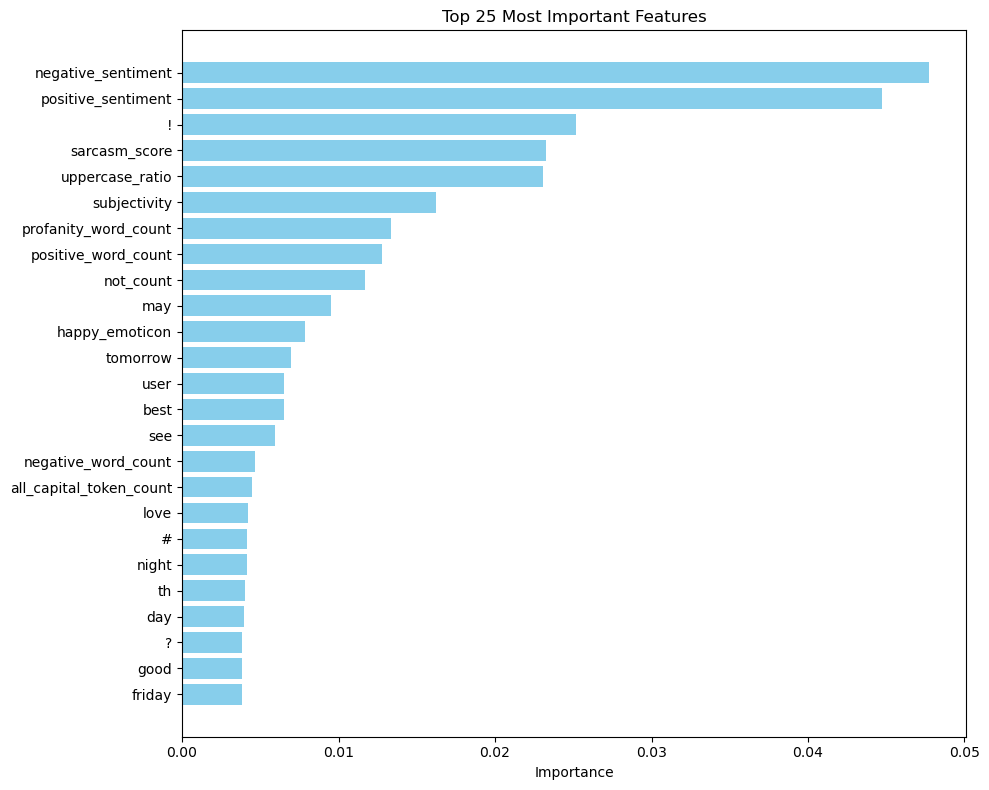

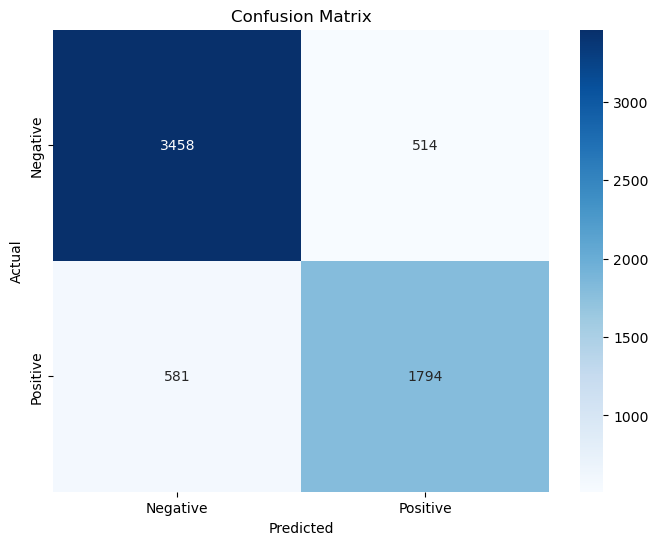

In [154]:
# Train a Random Forest on your features
model_rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model_rf.fit(X_train_final, y_train)
# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_final.columns,
    'importance': model_rf.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Display top 25 features
print("\nTop 25 Most Important Features:")
print(feature_importances.head(25))

# Plot top 25 features
plt.figure(figsize=(10, 8))
top_25 = feature_importances.head(25)
plt.barh(range(len(top_25)), top_25['importance'].values,color='skyblue')
plt.yticks(range(len(top_25)), top_25['feature'].values)
plt.xlabel('Importance')
plt.title('Top 25 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()